In [2]:
!pip install av miditok py_midicsv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 44.9 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.1 MB/s eta 0:00:00:00:01


In [3]:
!pip install fastai

In [4]:
# token_id_to_token = {v: k for k, v in tokenizer.vocab.items()}
# token_id_to_token

In [5]:
import av
import numpy as np
import random

from transformers import VivitImageProcessor, VivitModel, VivitConfig, TransfoXLLMHeadModel, TransfoXLConfig
from huggingface_hub import hf_hub_download
# print(transformers.__version__)
import matplotlib.pyplot as plt
from torch import nn
import py_midicsv as pm
import torch
import torch.nn.functional as F

from PIL import Image
import os
from miditok import REMI, TokenizerConfig  # here we choose to use REMI
import miditok
from pathlib import Path
from torch.cuda.amp import autocast

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataloader import default_collate
from torch import optim

from tqdm import tqdm
import wandb

2024-04-26 15:59:38.393512: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 15:59:38.393616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 15:59:38.569187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
# elle
def read_frames_from_path(frames_path, indices, rgb=False):
    '''
    Read specific frames from a directory containing image files of video frames.
    Args:
        frames_path (str): Path to the directory containing frame images.
        indices (List[int]): List of frame indices to read.
    Returns:
        result (np.ndarray): numpy array of frames of shape (num_frames, height, width, 3).
    '''
    # List all files in the directory and sort them to maintain order
    all_files = sorted(os.listdir(frames_path))
    frames = []

    # Process only files at specific indices
    color_mode = 'RGB' if rgb else 'L'
    for idx in indices:
        if idx < len(all_files):
            file_path = os.path.join(frames_path, all_files[idx])
            with Image.open(file_path) as img:
                # Convert image to RGB to ensure consistency
                img = img.convert(color_mode)
                # Calculate differences to make the image square
                width, height = img.size
                max_side = max(width, height)
                # Create a new image with a black background
                new_img = Image.new(color_mode, (max_side, max_side))
                # Paste the original image onto the center of the new image
                new_img.paste(img, ((max_side - width) // 2, (max_side - height) // 2))
                frame_array = np.array(new_img)
                if color_mode == 'L':
                    # Expand dims to add the channel dimension, resulting in (H, W, 1)
                    frame_array = np.expand_dims(frame_array, axis=-1)
                frames.append(frame_array)

    stacked_frames = np.stack(frames, axis=0)
    return stacked_frames

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

In [12]:
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")

torch.Size([1, 32, 3, 224, 224])


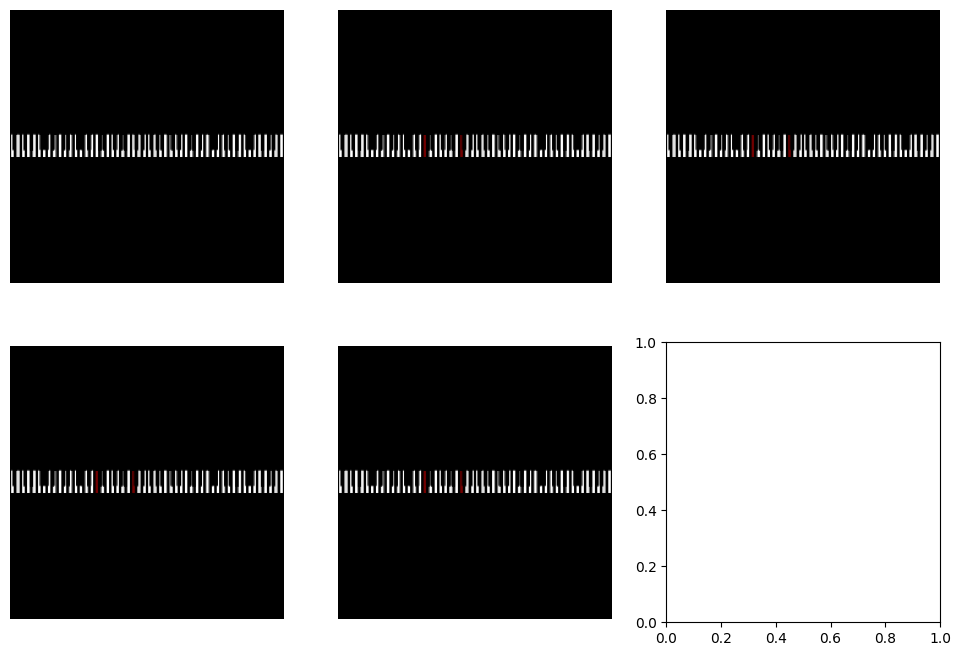

In [13]:
# sample 32 frames
# indices = sample_frame_indices(clip_len=1, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
# video = read_video_pyav(container=container, indices=indices)
# ds_dir = "../input/twinkle-fixed/data_sanity"
ds_dir = "../input/data-32fps/data_32fps"
# frames_path = f"{ds_dir}/processed/frames/somebody--twinke_twinkle_0"
frames_path = f"{ds_dir}/processed/frames/raw--twinke_twinkle_0"
# indices = sample_frame_indices(clip_len=32, frame_sample_rate=1)
indices = range(32)
video = read_frames_from_path(frames_path=frames_path, indices=indices, rgb=True)
inputs = image_processor(list(video), return_tensors="pt")
print(inputs["pixel_values"].shape)
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for i in range(5):
    ax[i // 3, i % 3].imshow(inputs["pixel_values"][0, i].permute(1, 2, 0).numpy())
    ax[i // 3, i % 3].axis("off")

In [14]:
class Video2MIDIDatasetTuple(Dataset):
    def __init__(self, root_dir, tokenizer, image_processor, transform=None, color_mode='gray'):
        self.root_dir = root_dir
        self.frames_dir = os.path.join(root_dir, 'frames')
        self.midi_dir = os.path.join(root_dir, 'midi')
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.transform = transform
        self.piece_names = [d for d in os.listdir(self.frames_dir) if os.path.isdir(os.path.join(self.frames_dir, d))]
        self.piece_names = [self.piece_names[0]] # TODO: remove!!!
        assert self.piece_names, f"frame_dir at {self.frames_dir} is empty!"
        self.color_mode = 'L' if color_mode == 'gray' else 'RGB'

    def __len__(self):
        return len(self.piece_names)

    def __getitem__(self, idx):
        piece_name = self.piece_names[idx]
        frames_path = os.path.join(self.frames_dir, piece_name)
        midi_path = os.path.join(self.midi_dir, f'{piece_name}.mid')

        midi_token_ids = self.load_midi(midi_path)
        frames = self.load_frames(frames_path, rgb=True)
#         img_side_width = 64
#         img_size = (img_side_width,img_side_width)
#         print(frames.shape, type(frames))
        # NOTE (elle): MUST convert frames to list for some reason otherwise it complains!!!
#         processed_frames = self.image_processor(list(frames), return_tensors="pt", do_center_crop=False, do_resize=True, size=img_size)
        processed_frames = image_processor(list(video), return_tensors="pt")
#         print(processed_frames)
#         sample = {'frames': processed_frames['pixel_values'], 'midi_tokens': midi_token_ids}
        return (processed_frames['pixel_values'], midi_token_ids)

#     def load_frames(self, frames_path):
#         frame_files = sorted(os.listdir(frames_path))
#         frames = [Image.open(os.path.join(frames_path, f)).convert(self.color_mode) for f in frame_files]
#         print(f"img shape: {print(frames[0].size)}")
#         if self.transform:
#             frames = [self.transform(frame) for frame in frames]
#         return frames

    def load_frames(self, frames_path, rgb=False):
        '''
        Read specific frames from a directory containing image files of video frames.
        Args:
            frames_path (str): Path to the directory containing frame images.
            indices (List[int]): List of frame indices to read.
        Returns:
            result (np.ndarray): numpy array of frames of shape (num_frames, height, width, 3).
        '''
        # List all files in the directory and sort them to maintain order
        frame_names = sorted(os.listdir(frames_path))
        frames = []

        # Process only files at specific indices
        color_mode = 'RGB' if rgb else 'L'
        for frame_name in frame_names:
            file_path = f"{frames_path}/{frame_name}"
            with Image.open(file_path) as img:
                # Convert image to RGB to ensure consistency
                img = img.convert(color_mode)
                # Calculate differences to make the image square
                width, height = img.size
                max_side = max(width, height)
                # Create a new image with a black background
                new_img = Image.new(color_mode, (max_side, max_side))
                # Paste the original image onto the center of the new image
                new_img.paste(img, ((max_side - width) // 2, (max_side - height) // 2))
                frame_array = np.array(new_img)
                if color_mode == 'L':
                    # Expand dims to add the channel dimension, resulting in (H, W, 1)
                    frame_array = np.expand_dims(frame_array, axis=-1)
                frames.append(frame_array)

        stacked_frames = np.stack(frames, axis=0)
        return stacked_frames

    def load_midi(self, midi_path):
        midi_tokens = self.tokenizer(midi_path)
        midi_token_ids = torch.tensor(midi_tokens[0].ids, dtype=torch.long)
        return midi_token_ids

In [15]:
class Video2MIDIDataset(Dataset):
    def __init__(self, root_dir, tokenizer, image_processor, transform=None, color_mode='gray'):
        self.root_dir = root_dir
        self.frames_dir = os.path.join(root_dir, 'frames')
        self.midi_dir = os.path.join(root_dir, 'midi')
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.transform = transform
        self.piece_names = [d for d in os.listdir(self.frames_dir) if os.path.isdir(os.path.join(self.frames_dir, d))]
        self.piece_names = [self.piece_names[0]] # TODO: remove!!!
        assert self.piece_names, f"frame_dir at {self.frames_dir} is empty!"
        self.color_mode = 'L' if color_mode == 'gray' else 'RGB'

    def __len__(self):
        return len(self.piece_names)

    def __getitem__(self, idx):
        piece_name = self.piece_names[idx]
        frames_path = os.path.join(self.frames_dir, piece_name)
        midi_path = os.path.join(self.midi_dir, f'{piece_name}.mid')

        midi_token_ids = self.load_midi(midi_path)
        frames = self.load_frames(frames_path, rgb=True)
#         img_side_width = 64
#         img_size = (img_side_width,img_side_width)
#         print(frames.shape, type(frames))
        # NOTE (elle): MUST convert frames to list for some reason otherwise it complains!!!
#         processed_frames = self.image_processor(list(frames), return_tensors="pt", do_center_crop=False, do_resize=True, size=img_size)
        processed_frames = image_processor(list(video), return_tensors="pt")
#         print(processed_frames)
        sample = {'frames': processed_frames['pixel_values'], 'midi_tokens': midi_token_ids}
        return sample

#     def load_frames(self, frames_path):
#         frame_files = sorted(os.listdir(frames_path))
#         frames = [Image.open(os.path.join(frames_path, f)).convert(self.color_mode) for f in frame_files]
#         print(f"img shape: {print(frames[0].size)}")
#         if self.transform:
#             frames = [self.transform(frame) for frame in frames]
#         return frames

    def load_frames(self, frames_path, rgb=False):
        '''
        Read specific frames from a directory containing image files of video frames.
        Args:
            frames_path (str): Path to the directory containing frame images.
            indices (List[int]): List of frame indices to read.
        Returns:
            result (np.ndarray): numpy array of frames of shape (num_frames, height, width, 3).
        '''
        # List all files in the directory and sort them to maintain order
        frame_names = sorted(os.listdir(frames_path))
        frames = []

        # Process only files at specific indices
        color_mode = 'RGB' if rgb else 'L'
        for frame_name in frame_names:
            file_path = f"{frames_path}/{frame_name}"
            with Image.open(file_path) as img:
                # Convert image to RGB to ensure consistency
                img = img.convert(color_mode)
                # Calculate differences to make the image square
                width, height = img.size
                max_side = max(width, height)
                # Create a new image with a black background
                new_img = Image.new(color_mode, (max_side, max_side))
                # Paste the original image onto the center of the new image
                new_img.paste(img, ((max_side - width) // 2, (max_side - height) // 2))
                frame_array = np.array(new_img)
                if color_mode == 'L':
                    # Expand dims to add the channel dimension, resulting in (H, W, 1)
                    frame_array = np.expand_dims(frame_array, axis=-1)
                frames.append(frame_array)

        stacked_frames = np.stack(frames, axis=0)
        return stacked_frames

    def load_midi(self, midi_path):
        midi_tokens = self.tokenizer(midi_path)
        midi_token_ids = torch.tensor(midi_tokens[0].ids, dtype=torch.long)
        return midi_token_ids

def custom_collate_fn(batch, tokenizer):
    # Extract frames and midi_tokens from the batch
    frames = [item['frames'] for item in batch]
    midi_tokens = [item['midi_tokens'] for item in batch]
    
    # Pad the midi_tokens
    # Assuming tokenizer provides PAD token index via tokenizer['PAD_None']
    pad_token_index = tokenizer['PAD_None']  # Ensure this is the correct index for your PAD token
    # print length before padding
#     print("Length before padding: ", [len(midi_token) for midi_token in midi_tokens])
    midi_tokens_padded = pad_sequence(midi_tokens, batch_first=True, padding_value=pad_token_index)
#     print("Length after padding: ", [len(midi_token) for midi_token in midi_tokens_padded])
    
    # Collate frames normally (assuming they are tensors of the same shape)
    frames = default_collate(frames)

    # Return a new dictionary with padded midi_tokens and frames
    return {'frames': frames, 'midi_tokens': midi_tokens_padded}
    
def show_images_and_midi(dataloader):
    for i, batch in enumerate(dataloader):
        frames = batch['frames']  # Assuming frames are tensors of shape (batch_size, channels, extra_dim, another_channel_like, height, width)
        midi_tokens = batch['midi_tokens']  # MIDI tokens

        print(f"Batch {i + 1}")

        # Calculate the number of rows and columns for the subplots
        batch_size = frames.size(0) # torch.Size([4, 1, 302, 1, 64, 64])
#         n_igms_in_batch = frames.size(2)
        cols = int(np.ceil(np.sqrt(batch_size)))
        rows = int(np.ceil(batch_size / cols))

        # Displaying images in a grid that's as square as possible
        fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))  # Adjust size as needed
        axs = axs.flatten()  # Flatten the array of axes to make indexing easier

        for j in range(batch_size):
            # Select the first image from the video sequence and remove the singleton dimensions
            img = frames[j, 0, 0, 0]  # Reduces to (64, 64)
            axs[j].imshow(img.numpy())
            axs[j].axis('off')  # Hide axes
            axs[j].set_title(f'MIDI: {midi_tokens[j]}')  # Optionally print MIDI token IDs

        # Hide any unused axes if the total number of subplots exceeds the batch size
        for k in range(batch_size, len(axs)):
            axs[k].axis('off')

        plt.show()

        # Optional: stop after first batch for demonstration
        if i == 0:
            break

def show_frames(frames):
    print("First Batch")

    # Calculate the total number of images to display
    total_images = len(frames)  # Assuming 'extra_dim' holds 32 images

    cols = int(np.ceil(np.sqrt(total_images)))
    rows = int(np.ceil(total_images / cols))

    # Displaying images in a grid that's as square as possible
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))  # Adjust size as needed
    axs = axs.flatten()  # Flatten the array of axes to make indexing easier

    for j in range(total_images):
        # Select the image from the video sequence for each frame in the batch
        img = frames[j]  # Adjust indexing based on your data's shape, using the first item in batch
        axs[j].imshow(img.numpy())
        axs[j].axis('off')  # Hide axes
        axs[j].set_title(f'MIDI: {midi_tokens[0]}')  # Optionally print MIDI token IDs for the first item in batch

    # Hide any unused axes if the total number of subplots exceeds the total images
    for k in range(total_images, len(axs)):
        axs[k].axis('off')

    plt.show()
    
def show_images_and_midi_one_batch(dataloader, tokenizer):
    # Fetch the first batch from the dataloader
    token_id_to_token = {v: k for k, v in tokenizer.vocab.items()}
    batch = next(iter(dataloader))
    batch_i = 0
    frames = batch['frames']  # Assuming frames are tensors of shape (batch_size, channels, extra_dim, another_channel_like, height, width)
    # ^ [4, 1, 32, 3, 224, 224]
    midi_tokens = batch['midi_tokens']  # MIDI tokens
    print(f"miditokens shape {midi_tokens.shape}")
    print("First Batch")

    # Calculate the total number of images to display
    total_images = frames.size(2)  # Assuming 'extra_dim' holds 32 images

    cols = int(np.ceil(np.sqrt(total_images)))
    rows = int(np.ceil(total_images / cols))

    # Displaying images in a grid that's as square as possible
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))  # Adjust size as needed
    axs = axs.flatten()  # Flatten the array of axes to make indexing easier
    
    midi_translations = []
    midis = []
    tokenss = []
    for j in range(total_images):
        # Select the image from the video sequence for each frame in the batch
        img = frames[0, 0, j] # Adjust indexing based on your data's shape, using the first item in batch
        axs[j].imshow(img.permute(1, 2, 0).numpy())
        axs[j].axis('off')  # Hide axes
        tokens = midi_tokens[batch_i]
        tokenss.append(tokens)
        midi = tokenizer([tokens])
        midis.append(midi)
        midi_translation = [token_id_to_token[int(id_.detach().numpy())] for id_ in tokens]
        midi_translations.append(midi_translation)
#         axs[j].set_title(f'MIDI: {midi_tokens_translated}')  # Optionally print MIDI token IDs for the first item in batch

    # Hide any unused axes if the total number of subplots exceeds the total images
    for k in range(total_images, len(axs)):
        axs[k].axis('off')

    title = f"{midis[batch_i]}\n{midi_translations[batch_i]}\n{tokenss[batch_i]}"
    fig.suptitle(title, fontsize=16)
    print(title)

    plt.show()

# dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
def collate_fn(batch):
    return custom_collate_fn(batch, tokenizer)

In [16]:
print("Creating dataset...")
ds_dir = "../input/data-32fps/data_32fps"
model_enc = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400")
# Our parameters
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 12): 4},
    "num_velocities": 32,
    "special_tokens": ["PAD", "BOS", "EOS", "MASK"],
    "use_chords": True,
    "use_rests": False,
    "use_tempos": True,
    "use_time_signatures": False,
    "use_programs": False,
    "num_tempos": 32,  # number of tempo bins
    "tempo_range": (40, 250),  # (min, max)
}
tok_config = TokenizerConfig(**TOKENIZER_PARAMS)

# Creates the tokenizer
tokenizer = REMI(tok_config)

dataset = Video2MIDIDataset(
    root_dir=f"{ds_dir}/processed",
    tokenizer=tokenizer,
    image_processor=image_processor
    # transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
)

dataloader = DataLoader(dataset, batch_size=2, shuffle=False, collate_fn=collate_fn) # [  4, 189, 308,  34, 112, 140,  49, 111, 134, 199,  49, 112, 130]), # [  4, 189, 308,  32, 109, 140,  44, 110, 134, 199,  44, 111, 130])
print(dataset.piece_names)

Creating dataset...


config.json:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/356M [00:00<?, ?B/s]

Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['raw--twinke_twinkle_0']


/tmp/ipykernel_34/1618119823.py:18: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  tok_config = TokenizerConfig(**TOKENIZER_PARAMS)


In [17]:
for data in dataloader:
    print('Frames shape:', data['frames'].shape, 'MIDI tokens shape:', data['midi_tokens'])

Frames shape: torch.Size([1, 1, 32, 3, 224, 224]) MIDI tokens shape: tensor([[  4, 189, 308,  32, 109, 140,  44, 110, 134, 199,  44, 111, 130]])


miditokens shape torch.Size([1, 13])
First Batch
Score(ttype=Tick, tpq=8, begin=0, end=16, tracks=1, notes=3, time_sig=1, key_sig=0, markers=0, lyrics=0)
['Bar_None', 'Position_0', 'Tempo_121.29', 'Pitch_48', 'Velocity_67', 'Duration_2.0.8', 'Pitch_60', 'Velocity_71', 'Duration_1.2.8', 'Position_10', 'Pitch_60', 'Velocity_75', 'Duration_0.6.8']
tensor([  4, 189, 308,  32, 109, 140,  44, 110, 134, 199,  44, 111, 130])


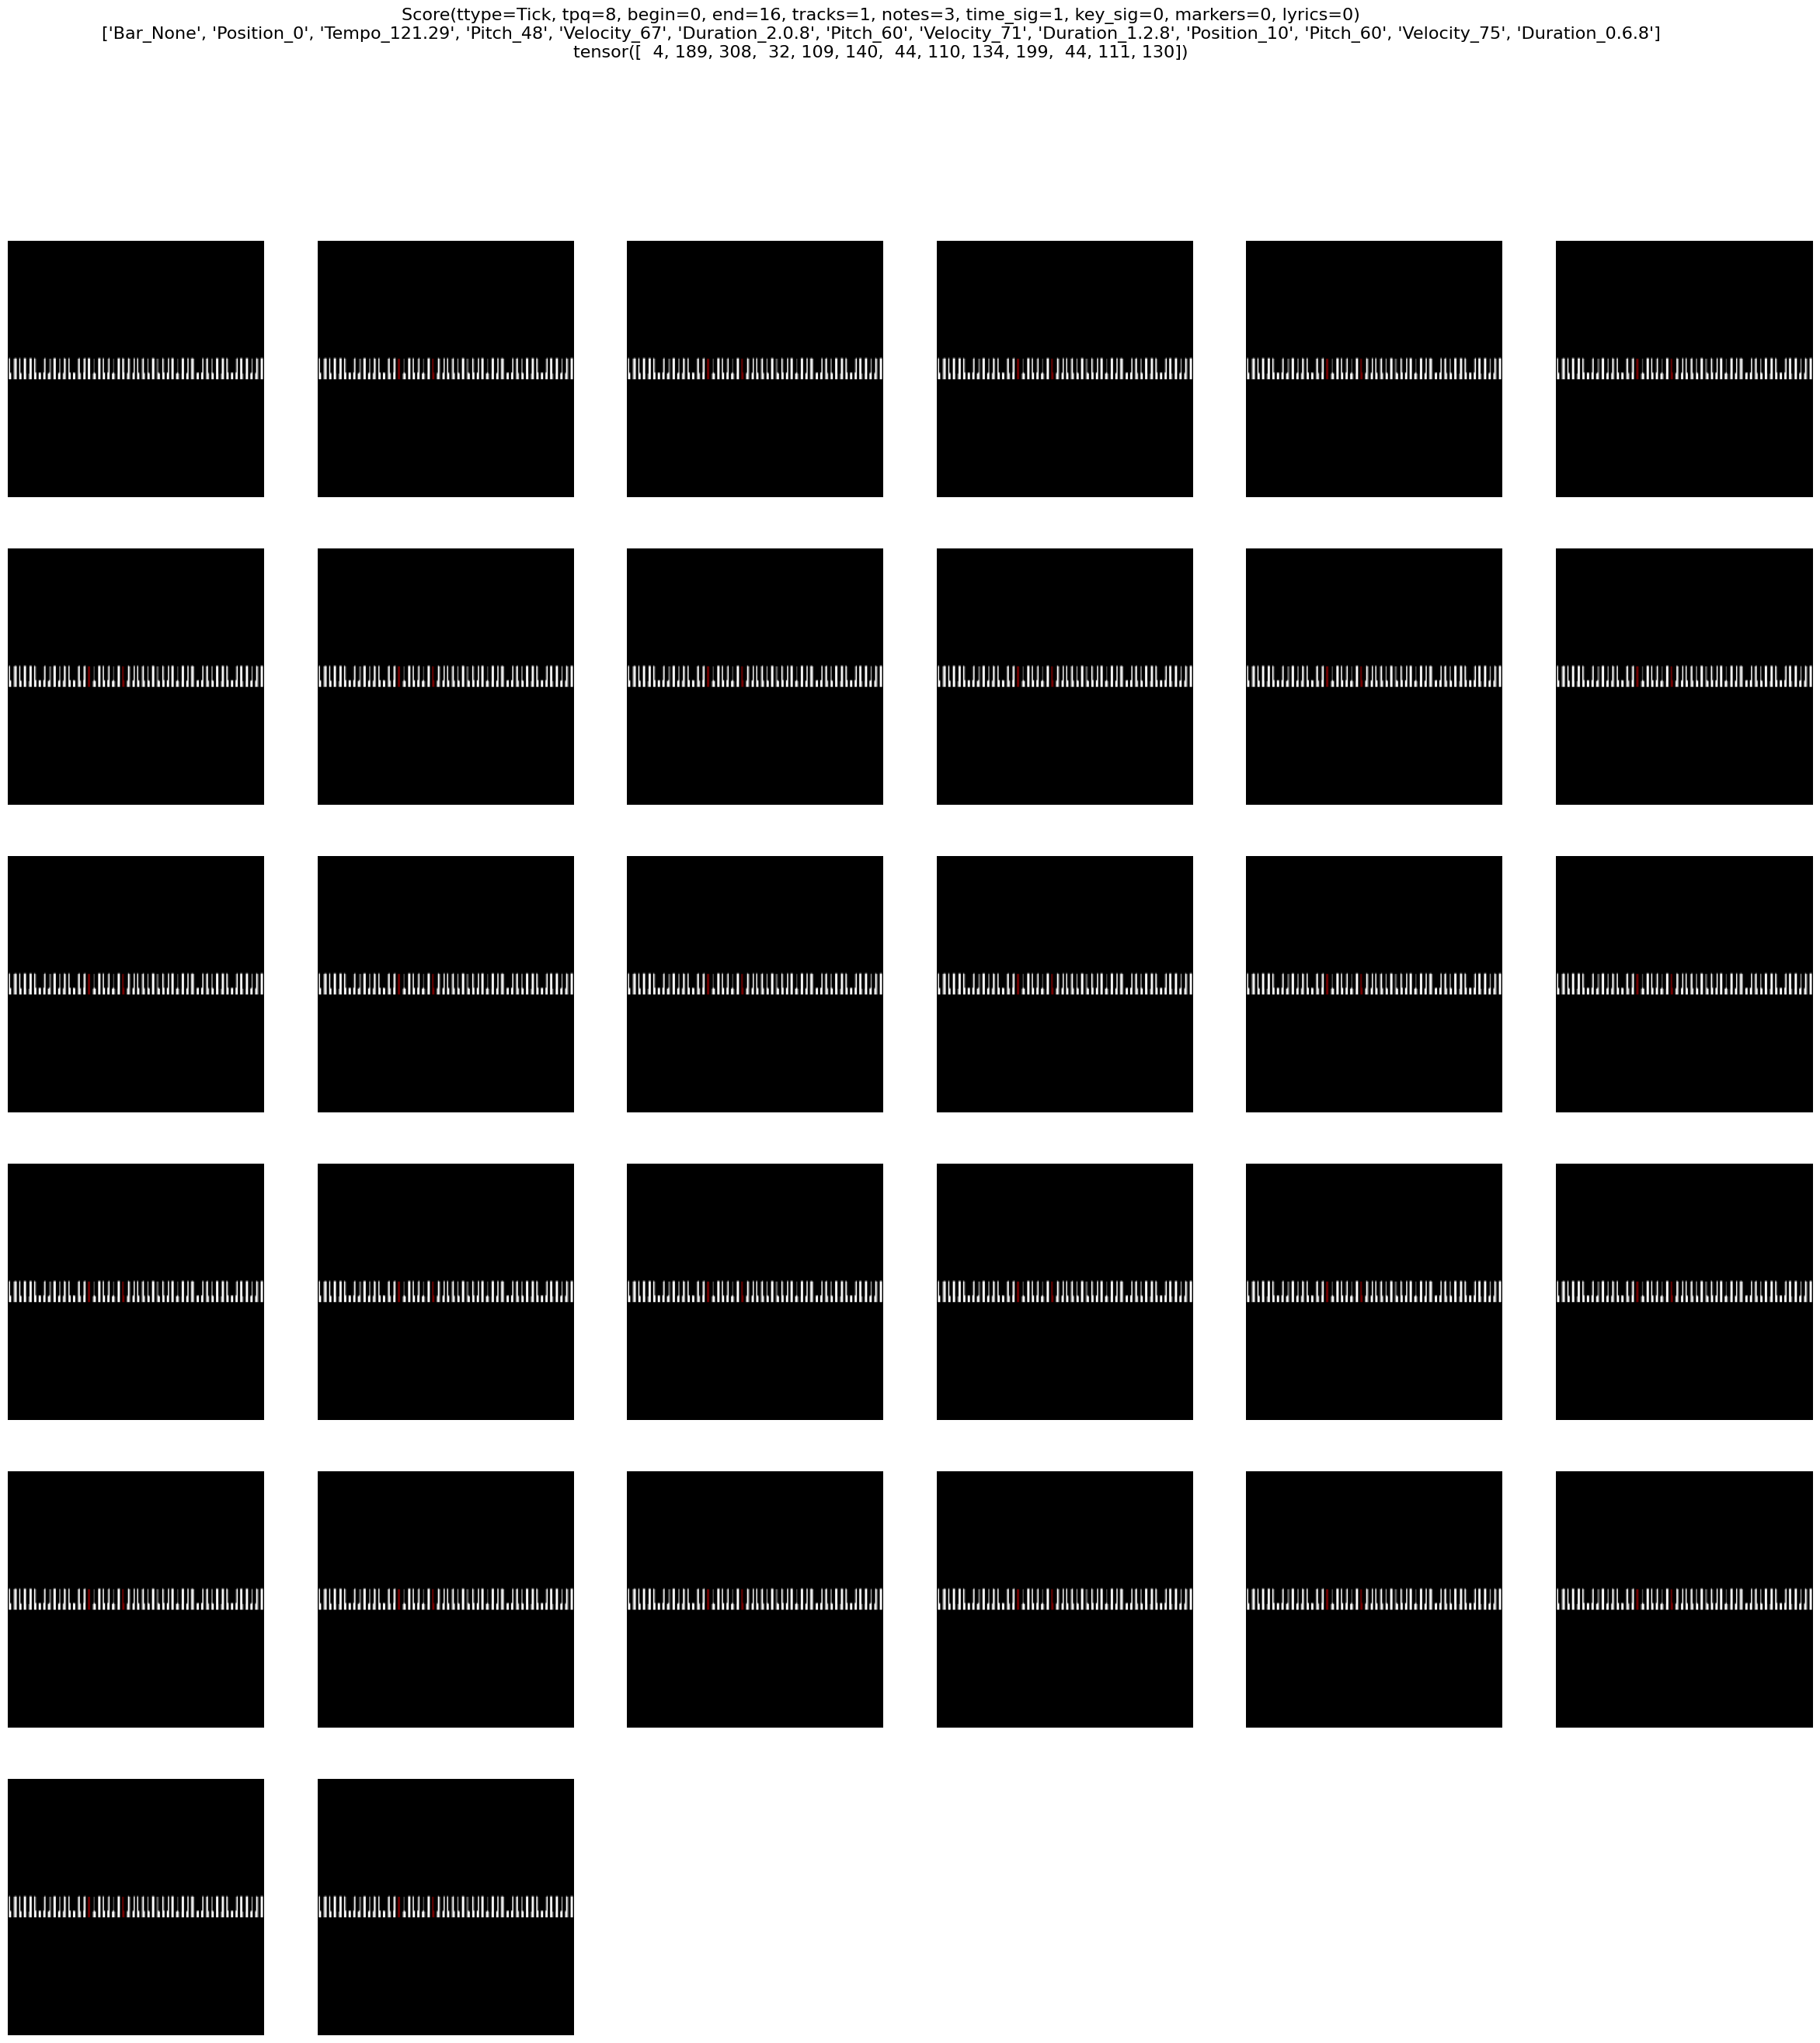

In [13]:
show_images_and_midi_one_batch(dataloader, tokenizer) # will take < 1 min to show

In [20]:
from transformers import SpeechT5ForSpeechToText, SpeechT5Config
from datasets import load_dataset

# dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
# dataset = dataset.sort("id")
# sampling_rate = dataset.features["audio"].sampling_rate
# example_speech = dataset[0]["audio"]["array"]

# processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_asr")
# model = SpeechT5ForSpeechToText.from_pretrained("microsoft/speecht5_asr")

# inputs = processor(audio=example_speech, sampling_rate=sampling_rate, return_tensors="pt")

# predicted_ids = model.generate(**inputs, max_length=100)

# torch.Size([1, 3137, 768]) size of encoder dimensions for 32 frame video, (batch, seq_len, embed_dim)
# so for some reason has a "sequence" length of 3137

config = SpeechT5Config(
    vocab_size=328,  # Your MIDI token vocabulary size
#     cutoffs=[],  # You might not need an adaptive softmax with a small vocabulary
    d_model=768,  # Lower dimensionality for a smaller model
#     d_embed=512,  # Same as d_model if not using adaptive embeddings
#     n_head=8,  # Fewer heads given the smaller model size
#     d_head=32,  # Lower dimensionality of model heads
#     d_inner=1024,  # Inner dimension of feed-forward layers
#     div_val=1,  # Since the vocab is small, might not need adaptive input
#     pre_lnorm=False,  # Default setting
#     n_layer=6,  # Fewer layers than a large-scale model
#     mem_len=128,  # Shorter memory length could suffice
#     clamp_len=-1,  # Clamp len set to -1 to use default behavior
#     same_length=False,  # Same length not necessary for smaller sequences
#     proj_share_all_but_first=False,  # Only share projections if model size increases
#     attn_type=0,  # Default Transformer-XL attention
#     sample_softmax=-1,  # With small vocab, full softmax is manageable
#     adaptive=False,  # No adaptive embeddings needed with small vocab
#     dropout=0.1,  # Standard dropout rate
#     dropatt=0.1,  # Attention dropout
#     untie_r=True,  # Typically we untie the biases
#     init="normal",  # Default initializer
#     init_range=0.1,  # Slightly larger initialization range
#     proj_init_std=0.1,  # Larger initialization for projections
#     init_std=0.02,  # Default initialization for weights
#     layer_norm_epsilon=1e-5,  # Default layer normalization epsilon
    decoder_start_token_id=tokenizer["EOS_None"], # TODO: double check! defaults to 2, is this used by the tokenize already? 4 is for Bar_None...
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],  # If you have a specific EOS token, otherwise the default is typically fine
    pad_token_id=tokenizer["PAD_None"] # TODO: do we need to configure any of this if the dataloader is already doing it???
)

model = SpeechT5ForSpeechToText(config)


In [15]:
# tokenizer.vocab.items()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_enc.to(device)
print(f"device {device}")

device cuda


In [17]:
with torch.no_grad():
    inputs = inputs.to(device)
    print(f"inputs shape {inputs['pixel_values'].shape}")
    with autocast():
        outputs = model_enc(**inputs)
        last_hidden_states = outputs.last_hidden_state
        print(last_hidden_states.shape)

inputs shape torch.Size([1, 32, 3, 224, 224])
torch.Size([1, 3137, 768])


In [18]:
batch = next(iter(dataloader))
batch_i = 0
frames = batch['frames'][0]  # Assuming frames are tensors of shape (batch_size, channels, extra_dim, another_channel_like, height, width)
print(f"frames shape {frames.shape}")
# ^ [4, 1, 32, 3, 224, 224] batch_size, num_frames, num_channels, height, width = pixel_values.shape
midi_tokens = batch['midi_tokens'][0]  # MIDI tokens
midi_tokens.to(device)
print(midi_tokens.shape)

frames shape torch.Size([1, 32, 3, 224, 224])
torch.Size([13])


In [19]:
print(type(inputs))

<class 'transformers.image_processing_utils.BatchFeature'>


In [20]:
with torch.no_grad():
    frames_input = frames.to(device)
    with autocast():
        print(frames_input.shape)
        outputs = model_enc(frames_input)
        last_hidden_states = outputs.last_hidden_state
        print(last_hidden_states.shape)

torch.Size([1, 32, 3, 224, 224])
torch.Size([1, 3137, 768])


In [21]:
# [  4, 189, 308,  32, 109, 140,  44, 110, 134, 199,  44, 111, 130]
# tensor([[ 44,  44,  44,  44,  44,  44,  44,  44,  44,  44, 111,  44, 110,  44,
#           44,  44,  44,  44,  44, 199]], device='cuda:0')

In [23]:
# loss_output = model(encoder_outputs=last_hidden_states, labels=midi_tokens.unsqueeze(0))

In [ ]:
# loss_output

In [18]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def cfg_to_dict(cfg):
    return {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}

In [22]:
# losses

In [ ]:
# !pip install lightning

In [ ]:
# import torch
# from torch.utils.data import DataLoader, TensorDataset
# import lightning as L

# class LitModel(L.LightningModule):
#     def __init__(self, model, encoder, learning_rate):
#         super().__init__()
#         self.learning_rate = learning_rate
#         self.model = model
#         self.encoder = encoder

#     def configure_optimizers(self):
#         optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
#         return optimizer

#     def forward(self, x):
#         # torch.Size([1, 32, 3, 224, 224]), torch.Size([20]) torch.float32 torch.int64
# #         frames, labels = torch.zeros(1, 32, 3, 224, 224, dtype=torch.float), torch.zeros(20, dtype=torch.int64)
#         frames = torch.zeros(1, 32, 3, 224, 224, dtype=torch.float)
#         labels = batch['midi_tokens'][0]
# #         print(f"labels {labels}")
#         frames = frames.to('cuda')
#         labels = labels.to('cuda')

#         # TODO: use non-finetuned video encoder???
#         # TODO: look at warning about some weights being uninitialized???
#         # NEXT todo: debug loss... why is it not overfitting..do I need to not index [0] or train on more varied data?
#         # or mess with the tokenizer..(nah probs not yet tbh)
#         # and how to handle non-determinism in decoder part?
#         # maybe the lr or some other hyperparam isn't great?
#         # why not use non-finetuned?
#         # google debugging stuff... maybe this isn't the right loss fxn somehow? or model isn't outputting logits idk if that's possible tbh
#         with torch.no_grad():
# #             with autocast():
#             outputs = self.encoder(frames)
#             last_hidden_states = outputs.last_hidden_state

#         # Model forward pass
# #         print(f"hidden states {last_hidden_states}")
#         return self.model(encoder_outputs=last_hidden_states, labels=labels.unsqueeze(0))

#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         outputs = self(x)
#         loss = outputs.loss #torch.nn.functional.cross_entropy(logits, y)
#         return loss

#     def train_dataloader(self):
#         # Dummy dataset and dataloader
# #         dataset = TensorDataset(torch.randn(100, 10), torch.randint(0, 5, (100,)))
#         dataset = Video2MIDIDataset(
#             root_dir=f"{ds_dir}/processed",
#             tokenizer=tokenizer,
#             image_processor=image_processor
#             # transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
#         )
# #         return DataLoader(dataset, batch_size=32)
#         return DataLoader(dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

# # Selects accelerator, devices and strategy automatically!
# # trainer = L.Trainer()
# # tuner = L.pytorch.tuner.Tuner(trainer)

# model = SpeechT5ForSpeechToText(config)
# model = model.to('cuda')  # Ensure your model is on GPU if available

# lit_model = LitModel(model, model_enc, .001)
# trainer = L.Trainer()
# tuner = L.pytorch.tuner.Tuner(trainer)

# # Run learning rate finder
# lr_finder = tuner.lr_find(lit_model)

# # Results can be found in
# print(lr_finder.results)

# # Plot with
# fig = lr_finder.plot(suggest=True)
# fig.show()

# # Pick point based on plot, or get suggestion
# new_lr = lr_finder.suggestion()

In [ ]:
# new_lr = lr_finder.suggestion()
# print(new_lr)

In [26]:
last_hidden_states.shape

torch.Size([1, 3137, 768])

In [23]:
# Model, optimizer, and criterion setup
class Config:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    SEED = 43
    USE_WANDB = False
    WANDB_PROJECT = "video2music"
    WANDB_ENTITY = "elles"
    WANDB_GROUP = "zero_encoder_emb_2digit_midi"
    EXPERIMENT = WANDB_GROUP
    
    LR = 0.001 # 4.786300923226385e-05 # 0.0001
    EPOCHS = 22
    
    FPS = 32

cfg = Config()

if cfg.SEED:
    set_seed(cfg.SEED)

if cfg.USE_WANDB:
    # convert cfg class to dict
    cfg_dict = cfg_to_dict(cfg)
    cfg_dict.update(config.to_dict())
    print(cfg_dict)
    assert cfg_dict != {}, "cfg_dict is empty"
    wandb_id = wandb.util.generate_id()
    wandb.init(
        project=cfg.WANDB_PROJECT,
        name=cfg.EXPERIMENT,
        entity=cfg.WANDB_ENTITY,
        config=cfg_dict,
        id=wandb_id,
        resume="allow",
        group=cfg.WANDB_GROUP
    )
    wandb.watch(model, log="all", log_freq=10)

config = SpeechT5Config(
    vocab_size=328,  # Your MIDI token vocabulary size
#     cutoffs=[],  # You might not need an adaptive softmax with a small vocabulary
    d_model=768,  # Lower dimensionality for a smaller model
#     d_embed=512,  # Same as d_model if not using adaptive embeddings
#     n_head=8,  # Fewer heads given the smaller model size
#     d_head=32,  # Lower dimensionality of model heads
#     d_inner=1024,  # Inner dimension of feed-forward layers
#     div_val=1,  # Since the vocab is small, might not need adaptive input
#     pre_lnorm=False,  # Default setting
#     n_layer=6,  # Fewer layers than a large-scale model
#     mem_len=128,  # Shorter memory length could suffice
#     clamp_len=-1,  # Clamp len set to -1 to use default behavior
#     same_length=False,  # Same length not necessary for smaller sequences
#     proj_share_all_but_first=False,  # Only share projections if model size increases
#     attn_type=0,  # Default Transformer-XL attention
#     sample_softmax=-1,  # With small vocab, full softmax is manageable
#     adaptive=False,  # No adaptive embeddings needed with small vocab
#     dropout=0.1,  # Standard dropout rate
#     dropatt=0.1,  # Attention dropout
#     untie_r=True,  # Typically we untie the biases
#     init="normal",  # Default initializer
#     init_range=0.1,  # Slightly larger initialization range
#     proj_init_std=0.1,  # Larger initialization for projections
#     init_std=0.02,  # Default initialization for weights
#     layer_norm_epsilon=1e-5,  # Default layer normalization epsilon
    decoder_start_token_id=tokenizer["EOS_None"], # TODO: double check! defaults to 2, is this used by the tokenize already? 4 is for Bar_None...
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],  # If you have a specific EOS token, otherwise the default is typically fine
    pad_token_id=tokenizer["PAD_None"] # TODO: do we need to configure any of this if the dataloader is already doing it???
)
model = SpeechT5ForSpeechToText(config)

model = model.to('cuda')  # Ensure your model is on GPU if available
model_enc = model_enc.to('cuda')
optimizer = optim.Adam(model.parameters(), lr=cfg.LR)

# Training loop
model.train()
# rand_labels = torch.rand(20, dtype=torch.int64)
lower_bound = 4
upper_bound = 5
rand_labels = torch.randint(lower_bound, upper_bound + 1, (5,), dtype=torch.int64)
# rand_labels = torch.ones(20, dtype=torch.int64) * 327
# rand_labels[-1] = 326
# rand_labels = torch.zeros(20, dtype=torch.int64)
for epoch in range(cfg.EPOCHS):
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{cfg.EPOCHS}')
    for batch in progress_bar:
#         frames = torch.zeros(1, 32, 3, 224, 224, dtype=torch.float)
#         labels = batch['midi_tokens'][0] OVERRIDE ACTUAL DATA WITH DEBUGGING PLACEHOLDER VALS
        labels = rand_labels
        print(f"labels {labels}")
#         frames = frames.to('cuda')
        labels = labels.to('cuda')
#         with torch.no_grad():
# #             with autocast():
#             outputs = model_enc(frames)
#             last_hidden_states = outputs.last_hidden_state
# #         last_hidden_states = ([1, 3137, 768])
        last_hidden_states = torch.zeros(1, 3137, 768, dtype=torch.float)
        last_hidden_states = last_hidden_states.to('cuda')

        # Model forward pass
        print(f"hidden states {last_hidden_states}")
        breakpoint()
        outputs = model(encoder_outputs=last_hidden_states, labels=labels.unsqueeze(0))

        # Loss computation
        loss = outputs.loss
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        progress_bar.set_postfix({'loss': loss.item()})

    # Logging to wandb
    average_loss = total_loss / len(dataloader)
    if wandb.run:
#         wandb.log({'train/MSE_diffusion': epoch_loss})
        wandb.log({'epoch': epoch, 'loss': average_loss})

    print(f'Epoch {epoch+1}, Loss: {average_loss:.4f}')

# End of training
# # [  4, 189, 308,  32, 109, 140,  44, 110, 134, 199,  44, 111, 130])
if wandb.run:
    wandb.finish()

Epoch 1/22:   0%|          | 0/1 [00:00<?, ?it/s]

labels tensor([5, 5, 4, 4, 4])
hidden states tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')


Epoch 1/22: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it, loss=6.01]


Epoch 1, Loss: 6.0107


Epoch 2/22: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it, loss=2.29]


labels tensor([5, 5, 4, 4, 4])
hidden states tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
Epoch 2, Loss: 2.2866


Epoch 3/22: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it, loss=9.85]


labels tensor([5, 5, 4, 4, 4])
hidden states tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
Epoch 3, Loss: 9.8494


Epoch 4/22: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it, loss=4.12]


labels tensor([5, 5, 4, 4, 4])
hidden states tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
Epoch 4, Loss: 4.1167


Epoch 5/22: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it, loss=1.13]


labels tensor([5, 5, 4, 4, 4])
hidden states tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
Epoch 5, Loss: 1.1329


Epoch 6/22: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it, loss=0.918]


labels tensor([5, 5, 4, 4, 4])
hidden states tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
Epoch 6, Loss: 0.9179


Epoch 7/22: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, loss=0.666]


labels tensor([5, 5, 4, 4, 4])
hidden states tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
Epoch 7, Loss: 0.6657


Epoch 8/22:   0%|          | 0/1 [00:01<?, ?it/s]


ValueError: Unable to create tensor, you should probably activate padding with 'padding=True' to have batched tensors with the same length.

In [ ]:
# # import torch
# # from torch import optim
# from fastai.text.all import *
# # from transformers import T5ForConditionalGeneration, T5Config
# # from tqdm import tqdm

# # # Configuration for your model (adjust according to your specific model needs)
# # config = T5Config.from_pretrained('t5-small')
# # model = T5ForConditionalGeneration(config)

# # # Dummy DataLoader
# # class DummyDataLoader(torch.utils.data.Dataset):
# #     def __init__(self, size=100):
# #         self.size = size

# #     def __len__(self):
# #         return self.size

# #     def __getitem__(self, idx):
# #         # Return dummy data: here we simulate video frames and corresponding MIDI tokens
# #         # Assuming video frames as 3D tensors (time, height, width) and MIDI tokens as 1D tensor
# #         return torch.zeros(1, 32, 3, 224, 224), torch.randint(0, 328, (20,))

# model = SpeechT5ForSpeechToText(config)
# # def tuple_wrapper(dataset):
# #     def _inner(idx):
# #         sample = dataset[idx]
# #         return (sample['frames'], sample['midi_tokens'])
# #     return _inner
# dataset_tuple = Video2MIDIDatasetTuple(
#     root_dir=f"{ds_dir}/processed",
#     tokenizer=tokenizer,
#     image_processor=image_processor
#     # transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
# )
# dls = DataLoaders.from_dsets(dataset_tuple, bs=1, device='cuda')  # Ensure your DataLoader is using the same device as model

# # Custom callback for handling specific batch operations
# class CustomBatchTransform(Callback):
#     def before_batch(self):
#         frames = torch.zeros(1, 32, 3, 224, 224, dtype=torch.float)
# #         labels = batch['midi_tokens'][0]
#         print(self.learn.yb[0])
#         labels = self.learn.yb[0]
#         print(f"labels {labels}")
#         frames = frames.to(self.learn.dls.device) 
#         labels = labels.to(self.learn.dls.device)

#         with torch.no_grad():
# #             with autocast():
#             outputs = model_enc(frames)
#             last_hidden_states = outputs.last_hidden_state

#         # Model forward pass
#         print(f"hidden states {last_hidden_states}")
#         print(f"shape {last_hidden_states.shape}")
#         self.learn.xb = (last_hidden_states,)  # Make sure to wrap in a tuple
#         self.learn.yb = (labels.unsqueeze(0),)

# # Setting up the Learner
# learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), opt_func=Adam, cbs=CustomBatchTransform(), metrics=accuracy)

# # Using fastai's learning rate finder
# lr_min, lr_steep = learn.lr_find()

# # Output the recommended learning rates
# print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

# # Example of a training loop using fastai
# learn.fit_one_cycle(1, lr_max=lr_min)  # Train for 1 epoch using the recommended lr_min

# # class CustomLearner(Learner):
# #     def one_batch(self, i, b):
# #         self.iter = i
# #         self._split(b)
# #         self('begin_batch')
# #         # Custom call to the model's forward pass
# #         self.pred = self.model(encoder_outputs=self.xb[0], labels=self.yb[0])
# #         self('after_pred')
# #         self.loss_grad = self.loss_func(self.pred, *self.yb)
# #         self.loss = self.loss_grad.clone()
# #         self('after_loss')
# #         if not self.training or not self.learn.yb: return
# #         self('before_backward')
# #         self.loss_grad.backward()
# #         self._with_events(self.opt.step, 'step', CancelStepException)
# #         self.opt.zero_grad()
# #         self('after_step')
# #         self('after_batch')

# # # Usage of CustomLearner
# # learn = CustomLearner(dls, model, loss_func=CrossEntropyLossFlat(), opt_func=Adam, cbs=CustomBatchTransform())
# # # Using fastai's learning rate finder
# # lr_min, lr_steep = learn.lr_find()
# # # Output the recommended learning rates
# # print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

# # # Example of a training loop using fastai
# # learn.fit_one_cycle(1, lr_max=lr_min)  # Train for 1 epoch using the recommended lr_min

In [ ]:
# input_values? labels?
# model.to(device)
last_hidden_states = last_hidden_states.to(device)
midi_tokens = midi_tokens.to(device)
model = model.to(device)
with torch.no_grad():
    output = model(encoder_outputs=last_hidden_states, decoder_input_ids=midi_tokens)
predicted_token_ids = torch.argmax(output.logits, dim=-1)
print(predicted_token_ids) # [  4, 189, 308,  32, 109, 140,  44, 110, 134, 199,  44, 111, 130])

In [35]:
print(tokenizer.special_tokens)
print(tokenizer.special_tokens_ids)

['PAD_None', 'BOS_None', 'EOS_None', 'MASK_None']
[0, 1, 2, 3]


In [ ]:
wandb.finish()

In [ ]:
# Model, optimizer, and criterion setup
cfg = Config()

if cfg.SEED:
    set_seed(cfg.SEED)

if cfg.USE_WANDB:
    # convert cfg class to dict
    cfg_dict = cfg_to_dict(cfg)
    print(cfg_dict)
    assert cfg_dict != {}, "cfg_dict is empty"
    wandb_id = wandb.util.generate_id()
    wandb.init(
        project=cfg.WANDB_PROJECT,
        name=cfg.EXPERIMENT,
        entity=cfg.WANDB_ENTITY,
        config=cfg_dict,
        id=wandb_id,
        resume="allow",
        group=cfg.WANDB_GROUP
    )
    wandb.watch(model, log="all", log_freq=10)

model = SpeechT5ForSpeechToText(config)

model = model.to('cuda')  # Ensure your model is on GPU if available
model_enc = model_enc.to('cuda')
optimizer = optim.Adam(model.parameters(), lr=cfg.LR)

# Training loop
model.train()
epochs = 100
for epoch in range(cfg.EPOCHS):
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{epochs}')
    for batch in progress_bar:
        optimizer.zero_grad()

        # Assuming your data loader returns batches of (inputs, labels)
        # TODO: double check don't need to offset lables by 1?
        # TODO: remove [0] here!! why doesn't it work with more batches???
        frames, labels = batch['frames'].squeeze(1), batch['midi_tokens']
        frames = frames.to('cuda')
        labels = labels.to('cuda')

        # NEXT TODO: explore diff architecture? Think default is set up for a smaller input size so...?
        # TODO: use non-finetuned video encoder???
        # TODO: look at warning about some weights being uninitialized???
        # NEXT todo: debug loss... why is it not overfitting..do I need to not index [0] or train on more varied data?
        # DEBUG shape '[2, -1, 12, 64]' is invalid for input of size 2409216 which happens once I add more than 1 directory hmmmm
        # or mess with the tokenizer..(nah probs not yet tbh)
        # and how to handle non-determinism in decoder part?
        # maybe the lr or some other hyperparam isn't great?
        with torch.no_grad():
#             with autocast():
                outputs = model_enc(frames)
                last_hidden_states = outputs.last_hidden_state

        # Model forward pass
        outputs = model(encoder_outputs=last_hidden_states, labels=labels.unsqueeze(0))

        # Loss computation
        loss = outputs.loss
        total_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        progress_bar.set_postfix({'loss': loss.item()})

    # Logging to wandb
    average_loss = total_loss / len(dataloader)
    if wandb.run:
#         wandb.log({'train/MSE_diffusion': epoch_loss})
        wandb.log({'epoch': epoch, 'loss': average_loss})

    print(f'Epoch {epoch+1}, Loss: {average_loss:.4f}')

# End of training
wandb.finish()

In [ ]:
from torch.nn import CrossEntropyLoss

In [ ]:
lm_logits.view(-1, 328).shape

In [ ]:
midi_tokens

In [ ]:
num_classes = 328

# One-hot encoding
lm_logits = torch.nn.functional.one_hot(midi_tokens, num_classes=num_classes)
lm_logits.shape

In [ ]:
print(lm_logits[0])

In [ ]:
labels.view(-1)

In [ ]:
loss_fct = CrossEntropyLoss()
lm_logits = torch.nn.functional.one_hot(midi_tokens, num_classes=328).float() * 10
# lm_logits 
labels = midi_tokens
loss = loss_fct(lm_logits.view(-1, 328), labels.view(-1))
print(loss)

In [ ]:
batch_size = 3
num_classes = 5

# Create dummy logits
# Normally, logits are outputs of a model and would not be manually set like this
logits = torch.tensor([
    [0.1, 0.2, 10.0, 0.1, 0.1],  # Logits for first sample, correct class index 2
    [0.1, 10.0, 0.2, 0.1, 0.1],  # Logits for second sample, correct class index 1
    [10.0, 0.1, 0.2, 0.1, 0.1]   # Logits for third sample, correct class index 0
], requires_grad=True)  # Enable gradient computation for backpropagation in training

# Correct labels corresponding to the highest logit score
labels = torch.tensor([2, 1, 0])  # Class indices
# Calculate cross-entropy loss
loss = F.cross_entropy(logits, labels)

# Print the loss
print("Cross-Entropy Loss:", loss.item())

In [10]:
from transformers import SpeechT5Processor, SpeechT5ForSpeechToText
from datasets import load_dataset

dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate
example_speech = dataset[0]["audio"]["array"]

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_asr")
model = SpeechT5ForSpeechToText.from_pretrained("microsoft/speecht5_asr")

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for hf-internal-testing/librispeech_asr_demo contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hf-internal-testing/librispeech_asr_demo
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating validation split: 0 examples [00:00, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/606M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at microsoft/speecht5_asr were not used when initializing SpeechT5ForSpeechToText: ['speecht5.encoder.prenet.pos_conv_embed.conv.weight_g', 'speecht5.encoder.prenet.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing SpeechT5ForSpeechToText from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SpeechT5ForSpeechToText from the checkpoint of a model that you expect to be exactly i

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [9]:
inputs = processor(audio=example_speech, sampling_rate=sampling_rate, return_tensors="pt")

NameError: name 'processor' is not defined

In [34]:
with torch.no_grad():
    predicted_ids = model.generate(**inputs, max_length=100)
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
    print(transcription[0])

mister quilter is the apostle of the middle classes and we are glad to welcome his gospel


In [35]:
processor.tokenizer

SpeechT5Tokenizer(name_or_path='microsoft/speecht5_asr', vocab_size=79, model_max_length=450, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	79: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
	80: AddedToken("<ctc_blank>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
}

In [36]:
model.config

SpeechT5Config {
  "_name_or_path": "microsoft/speecht5_asr",
  "activation_dropout": 0.1,
  "apply_spec_augment": true,
  "architectures": [
    "SpeechT5ForSpeechToText"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 12,
  "encoder_max_relative_position": 160,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_norm": "group",
  "feat_proj_dropout": 0.0,
  "guided_attention_loss_num_heads": 2,
  "guided_attention_loss_scale": 10.0,
  "guided_attention_loss_sigma": 